In [28]:
# ================================
# Cell 1 — Imports + helper funcs
# ================================

!pip install -q GEOparse scanpy anndata scikit-learn matplotlib seaborn pandas numpy joblib

import os, warnings
import numpy as np
import pandas as pd
import GEOparse

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


def load_gse(geo_id, destdir="geo_raw"):
    """Download + quick summary of a GSE."""
    print(f"\n==============================")
    print(f" LOADING: {geo_id}")
    print("==============================")
    gse = GEOparse.get_GEO(geo=geo_id, destdir=destdir, silent=True)

    # quick heuristic labels just for summary
    labels = []
    for gsm_id, gsm in gse.gsms.items():
        txt = " ".join(
            str(gsm.metadata.get(k, "")).lower()
            for k in ["title", "source_name_ch1", "characteristics_ch1", "description"]
        )
        if any(w in txt for w in ["normal", "control", "adjacent"]):
            labels.append("normal")
        elif any(w in txt for w in ["tumor", "tumour", "cancer", "carcinoma"]):
            labels.append("cancer")
        else:
            labels.append("unknown")
    label_series = pd.Series(labels, index=list(gse.gsms.keys()), name="label")

    print("Total samples:", label_series.shape[0])
    print(label_series.value_counts())
    print("\nPlatforms:")
    for pid in gse.gpls.keys():
        print(" -", pid)

    return gse


def load_gpl_annotation(gpl_id, destdir="geo_raw"):
    """Load platform annotation and return [ID, GENE] table."""
    print(f"\nDownloading annotation for {gpl_id} ...")
    gpl = GEOparse.get_GEO(geo=gpl_id, destdir=destdir, silent=True)

    ann = gpl.table.copy()
    ann.columns = [c.upper() for c in ann.columns]

    # find gene symbol column
    symbol_col = None
    for c in ["GENE SYMBOL", "GENE_SYMBOL", "GENE SYMBOLS", "GENE", "SYMBOL"]:
        if c in ann.columns:
            symbol_col = c
            break

    if symbol_col is None:
        raise ValueError(f"❌ Could not find gene symbol column in {gpl_id}")

    ann = ann[["ID", symbol_col]].rename(columns={symbol_col: "GENE"})
    ann["GENE"] = (
        ann["GENE"]
        .astype(str)
        .str.split("///").str[0]
        .str.strip()
    )
    ann = ann[ann["GENE"] != ""]
    return ann


def extract_expression_matrix(gse):
    """Extract sample × probe matrix from GSM tables."""
    exprs = {}
    for gsm_id, gsm in gse.gsms.items():
        tbl = gsm.table
        if tbl is None or tbl.empty:
            continue

        # probe column
        probe_col = None
        for c in ["ID_REF", "ID", "id_ref", "id"]:
            if c in tbl.columns:
                probe_col = c
                break
        if probe_col is None:
            continue

        # value column
        val_col = None
        for c in ["VALUE", "value", "Signal", "signal", "exprs", "intensity"]:
            if c in tbl.columns:
                val_col = c
                break
        if val_col is None:
            val_col = tbl.columns[-1]

        s = tbl[[probe_col, val_col]].dropna()
        s = s.set_index(probe_col)[val_col]
        exprs[gsm_id] = pd.to_numeric(s, errors="coerce")

    df = pd.DataFrame(exprs).transpose()
    df.index.name = "sample"
    return df


def extract_labels(gse):
    """Heuristic cancer/normal labels from GSM metadata."""
    labels = []
    for gsm_id, gsm in gse.gsms.items():
        txt = " ".join(
            str(gsm.metadata.get(k, "")).lower()
            for k in ["title", "source_name_ch1", "characteristics_ch1", "description"]
        )
        if any(w in txt for w in ["normal", "control", "adjacent"]):
            labels.append("normal")
        elif any(w in txt for w in ["tumor", "tumour", "cancer", "carcinoma"]):
            labels.append("cancer")
        else:
            labels.append("unknown")
    return pd.Series(labels, index=list(gse.gsms.keys()), name="label")


def map_probes_to_genes(expr_df, ann_df):
    """Convert probe-level matrix → gene-level matrix using platform annotation."""
    print("\nMatching probes ...")
    common = expr_df.columns.intersection(ann_df["ID"])
    print("Probes in both expr + annotation:", len(common))

    df = expr_df[common].copy()
    ann = ann_df.set_index("ID").loc[common]

    # rename columns to gene symbols
    df.columns = ann["GENE"].values

    # collapse duplicate gene symbols using new groupby syntax
    df_T = df.T
    df_T = df_T.groupby(df_T.index).mean()
    df_gene = df_T.T

    print("Final gene matrix shape:", df_gene.shape)
    return df_gene

In [29]:
# ============================================
# Cell 2 — Load train/test GSEs + ComBat
# ============================================
import scanpy as sc
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1) Load TRAIN and TEST GSE
gse_train = load_gse("GSE42568")   # larger, imbalanced
gse_test  = load_gse("GSE15852")   # smaller, balanced

# 2) Load platform annotations
ann_570 = load_gpl_annotation("GPL570")  # GSE42568
ann_96  = load_gpl_annotation("GPL96")   # GSE15852

# 3) Extract expression matrices (sample × probe)
X_train_probe = extract_expression_matrix(gse_train)
X_test_probe  = extract_expression_matrix(gse_test)

print("\nRaw probe matrices:")
print("Train (probes):", X_train_probe.shape)
print("Test  (probes):", X_test_probe.shape)

# 4) Extract labels
y_train_full = extract_labels(gse_train)
y_test_full  = extract_labels(gse_test)

print("\nLabel summary BEFORE filtering:")
print("TRAIN:\n", y_train_full.value_counts())
print("TEST:\n",  y_test_full.value_counts())

# Keep only cancer + normal
mask_train = y_train_full.isin(["cancer", "normal"])
mask_test  = y_test_full.isin(["cancer", "normal"])

y_train = y_train_full[mask_train]
y_test  = y_test_full[mask_test]

X_train_probe = X_train_probe.loc[y_train.index]
X_test_probe  = X_test_probe.loc[y_test.index]

print("\nAfter filtering to {cancer, normal}:")
print("Train labels:\n", y_train.value_counts())
print("Test  labels:\n", y_test.value_counts())

# 5) Map probes → genes
print("\nProcessing TRAIN (probe → gene) ...")
X_train_gene = map_probes_to_genes(X_train_probe, ann_570)

print("\nProcessing TEST (probe → gene) ...")
X_test_gene = map_probes_to_genes(X_test_probe, ann_96)

# Align label indices to gene matrices (just in case)
y_train = y_train.loc[X_train_gene.index]
y_test  = y_test.loc[X_test_gene.index]

print("\nGene matrices:")
print("Train (genes):", X_train_gene.shape)
print("Test  (genes):", X_test_gene.shape)

# 6) Keep only common genes between train + test
common_genes = sorted(set(X_train_gene.columns).intersection(X_test_gene.columns))
X_train_final = X_train_gene[common_genes].copy()
X_test_final  = X_test_gene[common_genes].copy()

print("\nCommon genes:", len(common_genes))
print("Final TRAIN matrix:", X_train_final.shape)
print("Final TEST  matrix:", X_test_final.shape)

# 7) ComBat batch correction across TRAIN/TEST
combined = pd.concat(
    [X_train_final, X_test_final],
    axis=0
)

batch = pd.Series(
    ["train"] * X_train_final.shape[0] + ["test"] * X_test_final.shape[0],
    index=combined.index,
    name="batch"
)

adata = sc.AnnData(combined)
adata.obs["batch"] = batch.values

print("\nRunning ComBat (train vs test as batches) ...")
sc.pp.combat(adata, key="batch")

X_corrected = pd.DataFrame(
    adata.X,
    index=combined.index,
    columns=combined.columns
)

# Split back into TRAIN/TEST
X_train_corr = X_corrected.loc[X_train_final.index]
X_test_corr  = X_corrected.loc[X_test_final.index]

# Safety: clip negatives (for log1p) + kill NaNs
X_train_corr = X_train_corr.clip(lower=0).fillna(0)
X_test_corr  = X_test_corr.clip(lower=0).fillna(0)

print("\nAfter ComBat + cleaning:")
print("Train corrected shape:", X_train_corr.shape)
print("Test  corrected shape:", X_test_corr.shape)

# Just so we see label balance clearly
print("\nFinal label counts:")
print("TRAIN:\n", y_train.value_counts())
print("TEST:\n",  y_test.value_counts())


 LOADING: GSE42568
Total samples: 121
label
cancer    104
normal     17
Name: count, dtype: int64

Platforms:
 - GPL570

 LOADING: GSE15852
Total samples: 86
label
normal    43
cancer    43
Name: count, dtype: int64

Platforms:
 - GPL96



Raw probe matrices:
Train (probes): (121, 54675)
Test  (probes): (86, 22283)

Label summary BEFORE filtering:
TRAIN:
 label
cancer    104
normal     17
Name: count, dtype: int64
TEST:
 label
normal    43
cancer    43
Name: count, dtype: int64

After filtering to {cancer, normal}:
Train labels:
 label
cancer    104
normal     17
Name: count, dtype: int64
Test  labels:
 label
normal    43
cancer    43
Name: count, dtype: int64

Processing TRAIN (probe → gene) ...

Matching probes ...
Probes in both expr + annotation: 54675
Final gene matrix shape: (121, 22881)

Processing TEST (probe → gene) ...

Matching probes ...
Probes in both expr + annotation: 22283
Final gene matrix shape: (86, 13238)

Gene matrices:
Train (genes): (121, 22881)
Test  (genes): (

Encoded classes: ['cancer' 'normal']

Before oversampling: [104  17]
After  oversampling: [104 104]

=============== RANDOM FOREST ===============
              precision    recall  f1-score   support

      cancer       0.51      1.00      0.67        43
      normal       1.00      0.02      0.05        43

    accuracy                           0.51        86
   macro avg       0.75      0.51      0.36        86
weighted avg       0.75      0.51      0.36        86

AUC: 0.8258518117901568


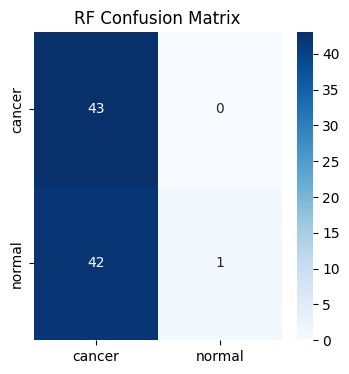


=============== MLP RESULTS ===============
              precision    recall  f1-score   support

      cancer       0.51      0.51      0.51        43
      normal       0.51      0.51      0.51        43

    accuracy                           0.51        86
   macro avg       0.51      0.51      0.51        86
weighted avg       0.51      0.51      0.51        86

AUC: 0.5110870740941049


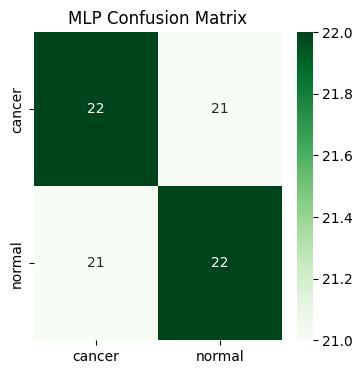

In [32]:
# ============================================================
# CELL 3 — SCALE → OVERSAMPLE → RF → MLP → METRICS
# ============================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1) LABEL ENCODING
# ----------------------------------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Encoded classes:", le.classes_)

# ----------------------------------------------------
# 2) SCALE (log1p + z-score)
# ----------------------------------------------------
X_train_scaled = np.log1p(X_train_corr)
X_test_scaled  = np.log1p(X_test_corr)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled  = scaler.transform(X_test_scaled)

# ----------------------------------------------------
# 3) OVERSAMPLE MINORITY MANUALLY (no imblearn)
# ----------------------------------------------------
counts = np.bincount(y_train_enc)
majority = np.argmax(counts)
minority = 1 - majority

idx_maj = np.where(y_train_enc == majority)[0]
idx_min = np.where(y_train_enc == minority)[0]

n_add = len(idx_maj) - len(idx_min)
idx_add = np.random.choice(idx_min, size=n_add, replace=True)

X_train_bal = np.concatenate([
    X_train_scaled[idx_maj],
    X_train_scaled[idx_min],
    X_train_scaled[idx_add]
], axis=0)

y_train_bal = np.concatenate([
    y_train_enc[idx_maj],
    y_train_enc[idx_min],
    y_train_enc[idx_add]
])

print("\nBefore oversampling:", counts)
print("After  oversampling:", np.bincount(y_train_bal))

# ----------------------------------------------------
# 4) RANDOM FOREST
# ----------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=8,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_bal, y_train_bal)
rf_pred = rf.predict(X_test_scaled)
rf_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("\n=============== RANDOM FOREST ===============")
print(classification_report(y_test_enc, rf_pred, target_names=le.classes_))
print("AUC:", roc_auc_score(y_test_enc, rf_proba))

cm_rf = confusion_matrix(y_test_enc, rf_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("RF Confusion Matrix")
plt.show()

# ----------------------------------------------------
# 5) MLP NEURAL NETWORK
# ----------------------------------------------------
X_train_bal_df = pd.DataFrame(X_train_bal).replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_df      = pd.DataFrame(X_test_scaled).replace([np.inf, -np.inf], np.nan).fillna(0)

X_train_clean = X_train_bal_df.values
X_test_clean  = X_test_df.values

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate='adaptive',
    early_stopping=True,
    max_iter=300,
    random_state=42
)

mlp.fit(X_train_clean, y_train_bal)

mlp_pred = mlp.predict(X_test_clean)
mlp_proba = mlp.predict_proba(X_test_clean)[:, 1]

print("\n=============== MLP RESULTS ===============")
print(classification_report(y_test_enc, mlp_pred, target_names=le.classes_))
print("AUC:", roc_auc_score(y_test_enc, mlp_proba))

cm_mlp = confusion_matrix(y_test_enc, mlp_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix")
plt.show()